# Finding Investment Opportunities - Analyzing S&P 500 Companies Using Value Investing Metrics

*Disclaimer: This project is meant for sharing and educational purpose only. This data and information presented do not constitute any form of investment advice.*

In this project, we aim to identify 10 fundamentally good companies which are relatively "under-valued" from the list of S&P 500 companies using value investing strategy.

We'll analyze the stock data obtained from different websites and data provider (API). To identify the 10 potential investment opportunities, we'll try to:
* Extract and compute the important fundamental statistics of S&P 500 companies 
* Identify the relatively high-performing and healthier companies using a customized value score
* Estimate the fair value of the selected companies using price-to-earnings (P/E) ratio valuation method

### Summary of Results

After analyzing the data, the 10 fundamentally good and relatively under-valued S&P 500 companies we identify are:
* Healthcare: **BIO, COO, VRTX, REGN, LH**
* Financials: **BRK.B, CINF**
* Information Technology: **AMD**
* Materials: **NEM**
* Real Estate: **KIM**

For more details, please refer to the full analysis below.

## Library Imports

The first thing we need to do is to import the libraries that we'll be using in this project.

In [1]:
%matplotlib inline
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from slugify import slugify

## Value Investing through Years

Before we start, let's first understand what value investing is. To put it simply, it means to buy a stock that appears to be trading for less than its intrinsic or book value. Imagine when you are stepping in a fast food restaurant (= market), your favorite chicken burger (= stock) is selling at 15% discount - this is exactly what we are interested to discover!

<img src="media/value-investing-concept.png" alt="value-investing" width="450px" height="200px">

<center><i>Image source: <a href="https://www.fool.com/investing/stock-market/types-of-stocks/value-stocks/value-investing-guide/">The Motley Fool</a></i></center>

[Value investing](https://www8.gsb.columbia.edu/valueinvesting/about/history) was developed in the 1920s at Columbia Business School by finance adjunct Benjamin Graham (1894-1976) and finance professor David Dodd (1885-1988). In 1934, they co-authored the classic text, *Security Analysis*. The discount of the market price to its intrinsic value is what Graham called "margin of safety". One of Graham's investing principle is "always invest with margin of safety" - e.g., buy assets worth $1 for 50 cents.

Warren Buffet, currently the Chairman and CEO of [Berkshire Hathaway](https://www.berkshirehathaway.com/), was an early disciple of Graham, and the best student in Graham’s investment course that he taught at Columbia. Buffet was a strong advocate of Graham's approach. He worked at Graham's investment company, before he took control of Berkshire Hathaway in 1965. 

Over the years, under the influence of his investment partner, Charlie Munger (joined Berkshire Hathaway as Vice Chairman since 1970s), Buffet's thinking on value has gradually changed. Instead of looking for a company with the greatest "margin of safety", he often says "It's better to buy a great company at a fair price, than a fair company at a great price."

Let's visualize the evolution of value investing by looking at a timeline.

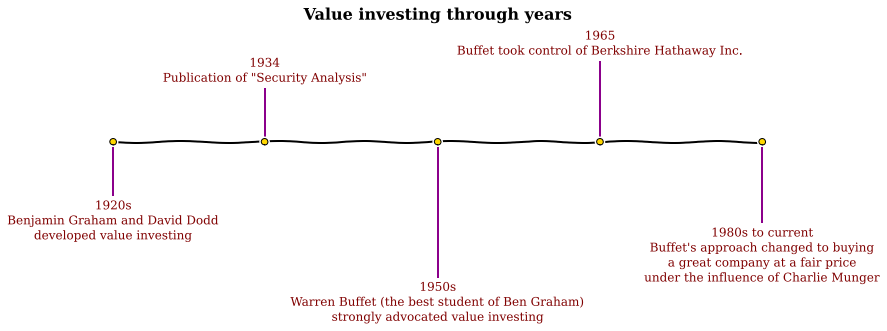

In [2]:
from datetime import datetime

# Define key events 
events = ["1920s\nBenjamin Graham and David Dodd\ndeveloped value investing", "1934\nPublication of \"Security Analysis\"", 
          "1950s\nWarren Buffet (the best student of Ben Graham)\nstrongly advocated value investing", "1965\nBuffet took control of Berkshire Hathaway Inc.",
          "1980s to current\nBuffet's approach changed to buying\na great company at a fair price\nunder the influence of Charlie Munger"]

# Define the timepoints and convert them to datetime objects for plotting
dates = ["1920", "1934", "1950", "1965", "1980"]
dates = [datetime.strptime(d, "%Y") for d in dates]

# Choose some nice levels
levels = [-0.1, 0.1, -0.25, 0.15, -0.15]

# Create sketch-style plot with xkcd
with plt.xkcd():
    
    # Create figure and plot a stem plot with the date
    fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)
    ax.set_title("Value investing through years", fontweight="bold", fontfamily="serif", fontsize="16", pad="30")

    ax.vlines(dates, 0, levels, color="darkmagenta")  # The vertical stems
    ax.plot(dates, np.zeros_like(dates), "-o",
            color="k", markerfacecolor="gold")  # Baseline and markers on it

    # Annotate lines
    for d, l, r in zip(dates, levels, events):
        ax.annotate(r, xy=(d, l), fontfamily="serif", fontsize="12", color="maroon",
                    xytext=(0, np.sign(l)*3), textcoords="offset points",
                    horizontalalignment="center",
                    verticalalignment="bottom" if l > 0 else "top")

    # Remove x & y axis and spines
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.spines[:].set_visible(False)

    plt.show()

## Taking a Closer Look at S&P 500 Companies

S&P 500 Index, or the Standard & Poor's 500 Index, is a market-capitalization-weighted index of the 500 largest publicly-traded companies in the U.S (i.e., more valuable companies account for higher weight of the index). Although being called as S&P 500, the index contains 505 stocks because it includes two share classes of stock from five companies. 

Before performing fundamental analysis, we need to have a list of the S&P 500 companies. Let's scrape this information from "List of S&P 500 companies" [wikipedia page](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies) using BeautifulSoup.

In [3]:
# Get a list of S&P 500 companies from wiki page in html format
sp500_wiki_request = requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
sp500_wiki_text = sp500_wiki_request.text

# Create a beautiful soup variable to parse the html
soup = BeautifulSoup(sp500_wiki_text, "html.parser")

We have successfully parsed the html of the website. Now, we need to identify the table containing S&P 500 companies. From the wikipedia page, we can see that the first table is what we want. 

In [4]:
# Identify S&P 500 table 
sp500_table = soup.find_all("table")[0]
sp500_table

<table class="wikitable sortable" id="constituents">
<tbody><tr>
<th><a href="/wiki/Ticker_symbol" title="Ticker symbol">Symbol</a>
</th>
<th>Security</th>
<th><a href="/wiki/SEC_filing" title="SEC filing">SEC filings</a></th>
<th><a href="/wiki/Global_Industry_Classification_Standard" title="Global Industry Classification Standard">GICS</a> Sector</th>
<th>GICS Sub-Industry</th>
<th>Headquarters Location</th>
<th>Date first added</th>
<th><a href="/wiki/Central_Index_Key" title="Central Index Key">CIK</a></th>
<th>Founded
</th></tr>
<tr>
<td><a class="external text" href="https://www.nyse.com/quote/XNYS:MMM" rel="nofollow">MMM</a>
</td>
<td><a href="/wiki/3M" title="3M">3M</a></td>
<td><a class="external text" href="https://www.sec.gov/cgi-bin/browse-edgar?CIK=MMM&amp;action=getcompany" rel="nofollow">reports</a></td>
<td>Industrials</td>
<td>Industrial Conglomerates</td>
<td><a href="/wiki/Saint_Paul,_Minnesota" title="Saint Paul, Minnesota">Saint Paul, Minnesota</a></td>
<td>1976-08

Right, we identify the correct table! Let's go through each row of the table and grab the information from each table cell. Our ultimate goal is to create a Pandas dataframe containing the ticker, company name, sector, date added to S&P 500 index, and date company founded.

In [5]:
# Create an empty list to store information of each company
companies = []

# Find all the rows in the table
rows = sp500_table.find_all("tr")

# Iterate over each row and locate the relevant cell
for row in rows[1:]: # Omit the first row - it contains the headers
    cells = row.find_all("td")
    ticker = cells[0].text.strip()
    company_name = cells[1].text.strip()
    sector = cells[3].text.strip()
    date_added = cells[6].text.strip()
    date_founded = cells[8].text.strip()
    companies.append([ticker, company_name, sector, date_added, date_founded])

# Ensure the extraction works correctly
print(companies[0]) # Test print a company
print(len(companies)) # Should print 505 as we have 505 entries in the table

['MMM', '3M', 'Industrials', '1976-08-09', '1902']
505


We are one-step away to create the dataframe of S&P 500 companies! Let's convert the list of list into a dataframe.

In [6]:
# Create a dataframe to store the S&P 500 companies
sp500_df = pd.DataFrame(companies, columns = ["Ticker", "Company Name", "Sector", "Date Added", "Date Founded"])
sp500_df.set_index("Ticker", inplace=True)
sp500_df.head()

,Company Name,Sector,Date Added,Date Founded
Ticker,,,,
MMM,3M,Industrials,1976-08-09,1902
ABT,Abbott Laboratories,Health Care,1964-03-31,1888
ABBV,AbbVie,Health Care,2012-12-31,2013 (1888)
ABMD,Abiomed,Health Care,2018-05-31,1981
ACN,Accenture,Information Technology,2011-07-06,1989


As mentioned earlier, in the S&P 500 companies, there are 5 companies with two share classes of stock. They are Alphabet Class A/Class C, Fox Corporation Class A/Class B, News Corp Class A/Class B, Under Armour Class A/Class C, and Discovery Series A/Series C.

In this project, we will remove Alphabet Class C *(Ticker: GOOG)*, Fox Corporation Class B *(Ticker: FOX)*, News Corp Class B *(Ticker: NWS)*, Under Armour Class C *(Ticker: UA)*, and Discovery Series C *(Ticker: DISCK)*.

In [7]:
sp500_df.drop(["GOOG", "FOX", "NWS", "UA", "DISCK"], axis=0, inplace=True)

Let's have a quick glance at the sector breakdown of the S&P 500 companies.

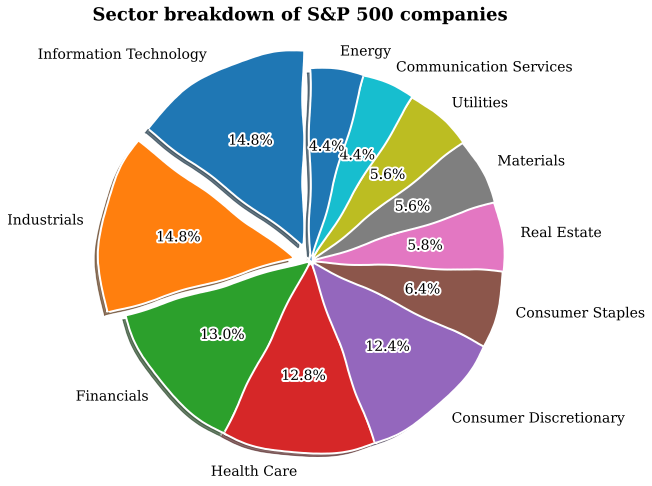

In [8]:
# Count number of companies in each sector 
sectors = sp500_df["Sector"].value_counts().reset_index()
sectors.rename(columns={"index":"Sector", "Sector":"Count"}, inplace=True)

# Create a pie chart to visualize the sector breakdown of S&P 500 companies
with plt.xkcd():
    fig1, ax1 = plt.subplots(figsize=(8,8))
    plt.rcParams["font.family"] = "serif"
    
    # Explode the first 2 slices with higher weightage
    explode = [0.1]*2 + [0]*9
    
    ax1.pie(sectors["Count"], explode=explode, labels=sectors["Sector"], autopct="%1.1f%%", shadow=True, startangle=90)
    ax1.set_title("Sector breakdown of S&P 500 companies", fontfamily="serif", fontsize="18", fontweight="bold", pad="15")
    
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  
    
    plt.show()

We can see that among all the S&P 500 companies, 14.8% of the companies are in information technology and industrials sector respectively. There are around 12-13% of companies in the sector of healthcare, financials and consumer discretionary, respectively. 

Other sectors include consumer stables, real estate, utilities, materials, communication services, and energy.

## Acquiring an API Token

Now, it's time to import our IEX Cloud API token. This is the [data provider]("https://iexcloud.io/") we'll be using.

API token is stored in a file called `secrets.py`. Please take note that for the purpose of this project, we'll be using a sandbox API token, which provides free and unlimited access for testing. The downside is that the sandbox data is intentionally manipulated by the data provider and is not accurate. As we are trying to illustrate the principles of value investing, we are not particularly concerned about the data accuracy at this stage.

The IEX cloud API documentation is available [here]("https://iexcloud.io/docs/api/").

In [9]:
# Import API token
from secrets import IEX_CLOUD_API_TOKEN

Let's try to make an API call to see if it's working.

In [10]:
# API call to get stock quote of Alphabet Inc.
symbol = "GOOGL"
api_url = f'https://sandbox.iexapis.com/stable/stock/{symbol}/quote?token={IEX_CLOUD_API_TOKEN}'
status = requests.get(api_url).status_code
print(status)

200


A HTTP 200 status code signifies that we have successfully retrieved information from the API call to IEX cloud.

## Obtain Fundamental Data of S&P 500 Companies

Let's now obtain some fundamental data of S&P 500 companies. Later in the project, we'll use these data to define our stock selection criteria based on value investing principles. 

First, we perform a batch API call, which is much faster compared to making single API calls iteratively. Before making a batch API call, we need to concatenate the company tickers into strings. Let's break up the list of tickers into manageable size.

In [11]:
# Functions sourced from https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# Break the stock tickers into lists of size of 100 each
ticker_groups = list(chunks(sp500_df.index, 100))
ticker_strings = []

# Concatenate ticker in each list to generate strings of ticker
for i in range(len(ticker_groups)):
    ticker_strings.append(",".join(ticker_groups[i]))
print(ticker_strings)

['MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALXN,ALGN,ALLE,LNT,ALL,GOOGL,MO,AMZN,AMCR,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,ANTM,AON,AOS,APA,AAPL,AMAT,APTV,ADM,ANET,AJG,AIZ,T,ATO,ADSK,ADP,AZO,AVB,AVY,BKR,BLL,BAC,BK,BAX,BDX,BRK.B,BBY,BIO,BIIB,BLK,BA,BKNG,BWA,BXP,BSX,BMY,AVGO,BR,BF.B,CHRW,COG,CDNS,CZR,CPB,COF,CAH,KMX,CCL,CARR,CTLT,CAT,CBOE,CBRE,CDW,CE,CNC,CNP,CERN,CF,CRL,SCHW', 'CHTR,CVX,CMG,CB,CHD,CI,CINF,CTAS,CSCO,C,CFG,CTXS,CLX,CME,CMS,KO,CTSH,CL,CMCSA,CMA,CAG,COP,ED,STZ,COO,CPRT,GLW,CTVA,COST,CCI,CSX,CMI,CVS,DHI,DHR,DRI,DVA,DE,DAL,XRAY,DVN,DXCM,FANG,DLR,DFS,DISCA,DISH,DG,DLTR,D,DPZ,DOV,DOW,DTE,DUK,DRE,DD,DXC,EMN,ETN,EBAY,ECL,EIX,EW,EA,EMR,ENPH,ETR,EOG,EFX,EQIX,EQR,ESS,EL,ETSY,EVRG,ES,RE,EXC,EXPE,EXPD,EXR,XOM,FFIV,FB,FAST,FRT,FDX,FIS,FITB,FE,FRC,FISV,FLT,FMC,F,FTNT,FTV,FBHS,FOXA', 'BEN,FCX,GPS,GRMN,IT,GNRC,GD,GE,GIS,GM,GPC,GILD,GL,GPN,GS,GWW,HAL,HBI,HIG,HAS,HCA,PEAK,HSIC,HSY,HES,HPE,HLT,HOLX,HD,HON,HRL,HST,HWM,HPQ,HUM,HBAN,HII,IEX,IDXX,

Now, We are ready to obtain information from the data provider and store them in a Pandas dataframe. For the purpose of subsequent analysis, we'll extract the following data: market capitalization, the revenue and EPS 12 quarters ago, TTM revenue and EPS, TTM operating cash flow, TTM Price-to-Earnings Ratio, and TTM Debt-to-Equity Ratio.

Based on the past and TTM revenue and EPS, we will compute the growth rate of revenue and EPS over the past 3 years (=12 quarters). The value score will be assigned at the end, depending on customized stock selection criteria, which will be defined later.

In [12]:
# Create a dataframe to store fundamental data of the S&P 500 companies
stats_columns = ["Ticker", "Market Capitalization ($ mil)", "Past Revenue (12 Quarters ago) ($ mil)", 
                "TTM Revenue ($ mil)", "Revenue CAGR", "Past EPS (12 Quarters ago)", "TTM EPS", "EPS CAGR", 
                "TTM Operating Cash Flow ($ mil)", "TTM Return on Equity", "TTM Price-to-Earnings Ratio",
                "TTM Debt-to-Equity Ratio", "Value Score"]
sp500_stats_df = pd.DataFrame(columns=stats_columns)
sp500_stats_df

,Ticker,Market Capitalization ($ mil),Past Revenue (12 Quarters ago) ($ mil),TTM Revenue ($ mil),Revenue CAGR,Past EPS (12 Quarters ago),TTM EPS,EPS CAGR,TTM Operating Cash Flow ($ mil),TTM Return on Equity,TTM Price-to-Earnings Ratio,TTM Debt-to-Equity Ratio,Value Score


In [13]:
# Perform batch API call for stock advanced stats and financial statements (up to latest 3 years)
for ticker_string in ticker_strings:
    batch_api_call_url = f'https://sandbox.iexapis.com/stable/stock/market/batch?symbols={ticker_string}&types=cash-flow,income,balance-sheet,quote,advanced-stats&period=quarter&last=12&token={IEX_CLOUD_API_TOKEN}'
    data = requests.get(batch_api_call_url).json()
    
    for ticker in ticker_string.split(","):
        
        market_cap = data[ticker]['advanced-stats']['marketcap']
        ttm_revenue = data[ticker]['advanced-stats']['totalRevenue']
        ttm_eps = data[ticker]['advanced-stats']['ttmEPS']
        ttm_shares_outstanding = data[ticker]['advanced-stats']['sharesOutstanding']
        pe_ratio = data[ticker]['quote']['peRatio']
        de_ratio = data[ticker]['advanced-stats']['debtToEquity']

        # Some companies do not have all financial data (income, balance sheet, cash flow) on IEX
        try:
            past_revenue = data[ticker]['income']['income'][-1]['totalRevenue'] 
        except KeyError:
            past_revenue = np.NaN
            
        # Calculate past EPS (oldest data in past 12 quarters) - divide net income by shares outstanding (common stock) 
        try:
            past_earning = data[ticker]['income']['income'][-1]['netIncome'] 
            past_shares_outstanding = data[ticker]['balance-sheet']['balancesheet'][-1]['commonStock'] 
            past_eps = past_earning / past_shares_outstanding
        except KeyError:
            past_eps = np.NaN
            
        # Get the latest operating cash flow (represented by cashFlow in IEX) 
        try:
            ttm_op_cf = data[ticker]['cash-flow']['cashflow'][0]['cashFlow'] 
        except KeyError:
            ttm_op_cf = np.NaN
            
        # Calculate ttm ROE 
        try:
            ttm_roe = 100 * data[ticker]['income']['income'][0]['netIncome'] / data[ticker]['balance-sheet']['balancesheet'][0]['shareholderEquity']
        except KeyError:
            ttm_roe = np.NaN
            
        # Set EPS CAGR and Revenue CAGR as NaN first, will compute using pandas.Series.apply function for faster computation
        revenue_cagr = eps_cagr = np.NaN
        
        # Set value score as 0 as this requires additional calculation
        value_score = 0
        
        # Append all the information into the dataframe
        sp500_stats_df = sp500_stats_df.append(
                                    pd.Series([ticker, market_cap, past_revenue, ttm_revenue, revenue_cagr, past_eps,
                                               ttm_eps, eps_cagr, ttm_op_cf, ttm_roe, pe_ratio, de_ratio, value_score
                                              ], index=stats_columns),
                                    ignore_index=True)


In [14]:
sp500_stats_df.head()

,Ticker,Market Capitalization ($ mil),Past Revenue (12 Quarters ago) ($ mil),TTM Revenue ($ mil),Revenue CAGR,Past EPS (12 Quarters ago),TTM EPS,EPS CAGR,TTM Operating Cash Flow ($ mil),TTM Return on Equity,TTM Price-to-Earnings Ratio,TTM Debt-to-Equity Ratio,Value Score
0,MMM,116018398991,8453412196,33502689327,NaN,3.060759,10.1,NaN,1693303684,12.079223,20.18,3.49271,0
1,ABT,203726698200,8086277931,37798680634,NaN,0.408907,3.3,NaN,2693330504,5.154480,36.79,2.21908,0
2,ABBV,206970952538,8658660576,52364586109,NaN,1.249678,2.97,NaN,5077495624,25.499876,38.84,11.0159,0
3,ABMD,14775106796,181693573,873459829,NaN,2.051983,4.97,NaN,86739528,4.295261,64.69,1.17887,0
4,ACN,202643661239,11138063635,45919512698,NaN,1.586601,8.54,NaN,2504500093,7.710220,36.34,2.28344,0


Yes! We have successfully consolidated the important value-investing metrics. Before defining the stock selection criteria and assigning the value score, we have to do some levels of data cleaning and manipulation.

## Data Cleaning 

### Handle Missing Data

Let's check if there are any null values in the dataframe apart from *Revenue CAGR* and *EPS CAGR* (we have specified them to be N/A earlier on).

In [15]:
sp500_stats_df.isnull().sum()

Ticker                                      0
Market Capitalization ($ mil)               1
Past Revenue (12 Quarters ago) ($ mil)      9
TTM Revenue ($ mil)                         9
Revenue CAGR                              500
Past EPS (12 Quarters ago)                  9
TTM EPS                                     9
EPS CAGR                                  500
TTM Operating Cash Flow ($ mil)             9
TTM Return on Equity                        9
TTM Price-to-Earnings Ratio                 9
TTM Debt-to-Equity Ratio                    9
Value Score                                 0
dtype: int64

From the null value summary statistics, we can see that there are some missing values in market capitalization, past revenue, TTM revenue, past EPS, TTM EPS, TTM operating cash flow, TTM ROE, TTM P/E Ratio and TTM D/E Ratio. Many of these can be attributed to the missing financial data (specifically income statement, balance sheet, and cash flow statement) from IEX data provider. Let's take a quick look on the rows containing missing data.

In [16]:
# Show rows with missing data
mask = sp500_stats_df["TTM Revenue ($ mil)"].isnull() | sp500_stats_df["Market Capitalization ($ mil)"].isnull()
missing = sp500_stats_df.loc[mask, :]
missing

,Ticker,Market Capitalization ($ mil),Past Revenue (12 Quarters ago) ($ mil),TTM Revenue ($ mil),Revenue CAGR,Past EPS (12 Quarters ago),TTM EPS,EPS CAGR,TTM Operating Cash Flow ($ mil),TTM Return on Equity,TTM Price-to-Earnings Ratio,TTM Debt-to-Equity Ratio,Value Score
41,AON,56508059738,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None,None,0
64,BRK.B,643160615985,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None,None,0
175,EVRG,14153050575,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None,None,0
191,FRC,33329864008,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None,None,0
352,OGN,7858383127,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None,None,0
381,PEG,30996861316,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None,None,0
408,STX,None,2837731664,10470755573,NaN,1.615517,4.08,NaN,380233858,65.377829,22.92,17.9984,0
428,TROW,45148747747,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None,None,0
455,UAL,17490127291,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None,None,0
469,VTRS,17631552498,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None,None,0


We can see a total of 10 companies with missing data of interest. As there is only missing market cap for STX, we will impute the market cap using data from [Yahoo Finance](https://finance.yahoo.com/quote/STX/). 

In [17]:
# Set the ticker as index for easy manipulation
sp500_stats_df.set_index("Ticker", inplace=True)

# Impute market cap of STX
sp500_stats_df.loc["STX", "Market Capitalization ($ mil)"] = 19.523 * 10**9
sp500_stats_df.loc["STX", :]

Market Capitalization ($ mil)              1.9523e+10
Past Revenue (12 Quarters ago) ($ mil)     2837731664
TTM Revenue ($ mil)                       10470755573
Revenue CAGR                                      NaN
Past EPS (12 Quarters ago)                    1.61552
TTM EPS                                          4.08
EPS CAGR                                          NaN
TTM Operating Cash Flow ($ mil)             380233858
TTM Return on Equity                          65.3778
TTM Price-to-Earnings Ratio                     22.92
TTM Debt-to-Equity Ratio                      17.9984
Value Score                                         0
Name: STX, dtype: object

If you might have noticed, Warren Buffet-owned Berkshire Hathaway class B share *(Ticker: BRK.B)* is also in the list of missing data. For this, we will impute the missing data using information of Berkshire Hathaway class A share *(Ticker: BRK.A)* as the data is largely similar, except for the EPS, which we will be able to adjust based on the class A/class B [conversion ratio](https://www.investopedia.com/ask/answers/021615/what-difference-between-berkshire-hathaways-class-and-class-b-shares.asp) of $1/1500^{th}$.

In [18]:
# Retrieve data of BRK.A from IEX
ticker = 'BRK.A'
api_url = f'https://sandbox.iexapis.com/stable/stock/market/batch?symbols={ticker}&types=cash-flow,income,balance-sheet,quote,advanced-stats&period=quarter&last=12&token={IEX_CLOUD_API_TOKEN}'
data = requests.get(api_url).json()

market_cap = data[ticker]['advanced-stats']['marketcap']
ttm_revenue = data[ticker]['advanced-stats']['totalRevenue']
ttm_eps = data[ticker]['advanced-stats']['ttmEPS'] / 1500 # 1 class A share is convertible to 1,500 class B shares
ttm_shares_outstanding = data[ticker]['advanced-stats']['sharesOutstanding']
pe_ratio = data[ticker]['quote']['peRatio']
de_ratio = data[ticker]['advanced-stats']['debtToEquity']
past_revenue = data[ticker]['income']['income'][-1]['totalRevenue'] 

# Calculate past EPS (oldest data in past 12 quarters) - divide net income by shares outstanding (common stock) 
past_earning = data[ticker]['income']['income'][-1]['netIncome'] 
past_shares_outstanding = data[ticker]['balance-sheet']['balancesheet'][-1]['commonStock'] 
past_eps = (past_earning / past_shares_outstanding) / 1500 # 1 class A share is convertible to 1,500 class B shares
ttm_op_cf = data[ticker]['cash-flow']['cashflow'][0]['cashFlow'] 
ttm_roe = 100 * data[ticker]['income']['income'][0]['netIncome'] / data[ticker]['balance-sheet']['balancesheet'][0]['shareholderEquity']
revenue_cagr = eps_cagr = value_score = 0

sp500_stats_df.loc["BRK.B", :] = [market_cap, past_revenue, ttm_revenue, revenue_cagr, past_eps, ttm_eps, 
                                  eps_cagr, ttm_op_cf, ttm_roe, pe_ratio, de_ratio, value_score]
sp500_stats_df.loc["BRK.B", :]

Market Capitalization ($ mil)             645384416656
Past Revenue (12 Quarters ago) ($ mil)     64995611761
TTM Revenue ($ mil)                       304090411172
Revenue CAGR                                         0
Past EPS (12 Quarters ago)                     4.87466
TTM EPS                                        45.2315
EPS CAGR                                             0
TTM Operating Cash Flow ($ mil)             9764286085
TTM Return on Equity                           2.68784
TTM Price-to-Earnings Ratio                       6.55
TTM Debt-to-Equity Ratio                       2.02836
Value Score                                          0
Name: BRK.B, dtype: object

For the remaining companies with missing values, we will drop them from our analysis. 

In [19]:
sp500_stats_df.dropna(subset=["Past Revenue (12 Quarters ago) ($ mil)"], inplace=True)
sp500_stats_df.shape

(492, 12)

We are now left with 492 companies, which is expected since we dropped eight companies (AON, EVRG, FRC, OGN, PEG, TROW, UAL, VTRS) from our dataset. 

### Convert Data to the Right Unit

For those of you with sharp eyes, you might have already noticed that the data we have for market capitalization, revenue, and operating cash flow are not in the right unit ($ mil). Let's convert now! 

In [20]:
# Express market cap, revenue and operating cf in ($ mil)
cols = ["Market Capitalization ($ mil)", "Past Revenue (12 Quarters ago) ($ mil)", "TTM Revenue ($ mil)", 
        "TTM Operating Cash Flow ($ mil)"]

# Need to convert cols to float type before converting to $ mil unit
sp500_stats_df.loc[:, cols] = sp500_stats_df.loc[:, cols].astype("float64").apply(lambda x: np.round(x / 1000000, 2))
sp500_stats_df.head(10)

,Market Capitalization ($ mil),Past Revenue (12 Quarters ago) ($ mil),TTM Revenue ($ mil),Revenue CAGR,Past EPS (12 Quarters ago),TTM EPS,EPS CAGR,TTM Operating Cash Flow ($ mil),TTM Return on Equity,TTM Price-to-Earnings Ratio,TTM Debt-to-Equity Ratio,Value Score
Ticker,,,,,,,,,,,,
MMM,116018.40,8453.41,33502.69,NaN,3.060759,10.1,NaN,1693.30,12.079223,20.18,3.49271,0
ABT,203726.70,8086.28,37798.68,NaN,0.408907,3.3,NaN,2693.33,5.154480,36.79,2.21908,0
ABBV,206970.95,8658.66,52364.59,NaN,1.249678,2.97,NaN,5077.50,25.499876,38.84,11.0159,0
ABMD,14775.11,181.69,873.46,NaN,2.051983,4.97,NaN,86.74,4.295261,64.69,1.17887,0
ACN,202643.66,11138.06,45919.51,NaN,1.586601,8.54,NaN,2504.50,7.710220,36.34,2.28344,0
ATVI,74953.43,1714.83,8647.87,NaN,0.544045,3.01,NaN,866.62,4.061971,31.97,1.57499,0
ADBE,284033.79,2242.99,13749.35,NaN,1.377782,11.93,NaN,1817.81,9.332844,51.8,1.9277,0
AMD,106847.36,1834.59,11461.30,NaN,0.116406,2.41,NaN,919.21,8.559235,36.06,1.57834,0
AAP,13874.85,2327.71,11190.64,NaN,1.578466,9.34,NaN,335.19,5.496404,22,3.50504,0


## Calculate CAGR - How Revenue and EPS Have Grown Over the Past Three Years?

We can move on to calculate Revenue CAGR and EPS CAGR. [CAGR](https://www.investopedia.com/terms/c/cagr.asp) stands for "Compound Annual Growth Rate", which is the rate of return that would be required for an investment to grow from its beginning balance to its ending balance. The word “compound” denotes the fact that CAGR takes into account the effects of compounding, or reinvestment, over time.

It is important to note that CAGR does not give a true return rate, but a representational figure. By using CAGR, the rate of return over the years "smoothens", and the significant short-term volatility (ups and downs) cannot be visualized. This might give an emotionally misleading impression of the stock performance.

Here, since we are talking about value investing strategy which focuses on long-term performance of a company, the shorter-term volatility is not too much of our concerns. We'll use CAGR to evaluate the growth rate of revenue and EPS over the past 3 years (12 quarters).

In [21]:
def cagr(starting_bal, ending_bal, period):
    """Calculate the rate of return over a certain period of time, expressed in annual percentage terms"""
    eb_by_sb = ending_bal / starting_bal
    
    # Numpy does not seem to allow fractional powers of negative numbers
    # Source of code: https://stackoverflow.com/questions/45384602/numpy-runtimewarning-invalid-value-encountered-in-power
    eb_by_sb_pow = np.sign(eb_by_sb) * (np.abs(eb_by_sb) ** (1 / period))
    
    return 100 * (eb_by_sb_pow - 1)

We have defined the function to calculate CAGR. Let's now apply it to calculate the growth of revenue and EPS.

In [22]:
# Convert all the datatypes to float for calculation
sp500_stats_df = sp500_stats_df.astype("float64")

# Calculate revenue CAGR over the past 3 years
revenue_cagr = cagr(np.array(sp500_stats_df.loc[:, "Past Revenue (12 Quarters ago) ($ mil)"]), 
                    np.array(sp500_stats_df.loc[:, "TTM Revenue ($ mil)"]), 3)
sp500_stats_df.loc[:, "Revenue CAGR"] = revenue_cagr

# Calculate EPS CAGR over the past 3 years
eps_cagr = cagr(np.array(sp500_stats_df.loc[:, "Past EPS (12 Quarters ago)"]),
                np.array(sp500_stats_df.loc[:, "TTM EPS"]), 3)
sp500_stats_df.loc[:, "EPS CAGR"] = eps_cagr

# Check if CAGR is computed correctly
sp500_stats_df.head()

,Market Capitalization ($ mil),Past Revenue (12 Quarters ago) ($ mil),TTM Revenue ($ mil),Revenue CAGR,Past EPS (12 Quarters ago),TTM EPS,EPS CAGR,TTM Operating Cash Flow ($ mil),TTM Return on Equity,TTM Price-to-Earnings Ratio,TTM Debt-to-Equity Ratio,Value Score
Ticker,,,,,,,,,,,,
MMM,116018.40,8453.41,33502.69,58.252015,3.060759,10.10,48.878072,1693.30,12.079223,20.18,3.492711,0.0
ABT,203726.70,8086.28,37798.68,67.202443,0.408907,3.30,100.584076,2693.33,5.154480,36.79,2.219080,0.0
ABBV,206970.95,8658.66,52364.59,82.191876,1.249678,2.97,33.450251,5077.50,25.499876,38.84,11.015901,0.0
ABMD,14775.11,181.69,873.46,68.773400,2.051983,4.97,34.295318,86.74,4.295261,64.69,1.178874,0.0
ACN,202643.66,11138.06,45919.51,60.347637,1.586601,8.54,75.252147,2504.50,7.710220,36.34,2.283442,0.0


## Assign Value Score to Each Company 

We finally have all the metrics we need to calculate the value score. Here, we'll assign one point each to the company's value score when the company fits one of the following criteria: (*Note: These criteria are selected based on personal view to reflect company's growth, health and value, you can modify the criteria depending on the metrics of your interest.)*
1. Positive revenue growth >= 10% 
2. Positive EPS growth >= 10%
3. Positive TTM operating cash flow
4. [P/E ratio](https://www.investopedia.com/terms/p/price-earningsratio.asp) lower than sector average (median)
5. [Return on Equity](https://www.investopedia.com/terms/r/returnonequity.asp) >= 15
6. [D/E ratio](https://www.investopedia.com/terms/d/debtequityratio.asp) lower than sector average (median)

Now, we'll join our two dataframes (`sp500_df`, `sp500_stats_df`) and combine all the information available in both dataframes together.

In [23]:
# Inner join two dataframes based on the index (ticker)
sp500_df_final = sp500_df.join(sp500_stats_df, how = "inner")
sp500_df_final.head()

# Alternative method: result = pd.merge(left, right, left_index=True, right_index=True, how="inner")

,Company Name,Sector,Date Added,Date Founded,Market Capitalization ($ mil),Past Revenue (12 Quarters ago) ($ mil),TTM Revenue ($ mil),Revenue CAGR,Past EPS (12 Quarters ago),TTM EPS,EPS CAGR,TTM Operating Cash Flow ($ mil),TTM Return on Equity,TTM Price-to-Earnings Ratio,TTM Debt-to-Equity Ratio,Value Score
Ticker,,,,,,,,,,,,,,,,
MMM,3M,Industrials,1976-08-09,1902,116018.40,8453.41,33502.69,58.252015,3.060759,10.10,48.878072,1693.30,12.079223,20.18,3.492711,0.0
ABT,Abbott Laboratories,Health Care,1964-03-31,1888,203726.70,8086.28,37798.68,67.202443,0.408907,3.30,100.584076,2693.33,5.154480,36.79,2.219080,0.0
ABBV,AbbVie,Health Care,2012-12-31,2013 (1888),206970.95,8658.66,52364.59,82.191876,1.249678,2.97,33.450251,5077.50,25.499876,38.84,11.015901,0.0
ABMD,Abiomed,Health Care,2018-05-31,1981,14775.11,181.69,873.46,68.773400,2.051983,4.97,34.295318,86.74,4.295261,64.69,1.178874,0.0
ACN,Accenture,Information Technology,2011-07-06,1989,202643.66,11138.06,45919.51,60.347637,1.586601,8.54,75.252147,2504.50,7.710220,36.34,2.283442,0.0


Before we are able to assign point based on stock selection criteria #4 and #6, we need to compute the average P/E and D/E of each sector. 

P/E ratio relates a company share price to its EPS - a high P/E ratio could mean that a company's stock is overvalued, or that investors are expecting high growth rates in the future. On the other hand, D/E ratio represents the financial health of a company. It is a measure of the degree to which a company is financing through debt *vs.* wholly-owned funds. Too high a D/E ratio means the company is financing its operations more through debt, which might associate with a higher risk.

Importantly, these two ratios often vary across different sectors. To have a fairer comparison, we will use average ratio of each sector as the benchmark. Here, we'll use "median" instead of "mean" to minimize the impact of an outlier. 

In [24]:
# Calculate median P/E of each sector
grouped_df = sp500_df_final.groupby("Sector").agg({"TTM Price-to-Earnings Ratio":np.median})

# Convert grouped_df to dict
pe_sector_median = grouped_df.to_dict()["TTM Price-to-Earnings Ratio"]
pe_sector_median

{'Communication Services': 20.77,
 'Consumer Discretionary': 21.98,
 'Consumer Staples': 24.975,
 'Energy': -11.315000000000001,
 'Financials': 14.29,
 'Health Care': 35.22,
 'Industrials': 30.7,
 'Information Technology': 38.71,
 'Materials': 28.185000000000002,
 'Real Estate': 47.95,
 'Utilities': 22.605}

In [25]:
# Calculate median D/E of each sector
grouped_df = sp500_df_final.groupby("Sector").agg({"TTM Debt-to-Equity Ratio":np.median})

# Convert grouped_df to dict
de_sector_median = grouped_df.to_dict()["TTM Debt-to-Equity Ratio"]
de_sector_median

{'Communication Services': 2.9605147636030607,
 'Consumer Discretionary': 3.5155667722509785,
 'Consumer Staples': 3.382114256073862,
 'Energy': 2.3816363913079286,
 'Financials': 7.996959001981525,
 'Health Care': 2.224358679491126,
 'Industrials': 2.692744928751308,
 'Information Technology': 2.2678651197546724,
 'Materials': 2.85453922214429,
 'Real Estate': 2.147712620540051,
 'Utilities': 3.7899272279956033}

Now, we're ready to assign value score (higher value score = overall stronger fundamentals, better financial health, and of good value) to each company. 

In [26]:
# Positive revenue CAGR, Positive EPS CAGR, Positive TTM operating cf, ROE >= 15, D/E <= 1
sp500_df_final["Value Score"] = (0 + (sp500_df_final["Revenue CAGR"] >= 10) + (sp500_df_final["EPS CAGR"] >= 10) + 
                                (sp500_df_final["TTM Operating Cash Flow ($ mil)"] > 0) + 
                                (sp500_df_final["TTM Return on Equity"] >= 15))
# P/E less than sector median
for row in sp500_df_final.index:
    if sp500_df_final.loc[row, "TTM Price-to-Earnings Ratio"] <= pe_sector_median[sp500_df_final.loc[row, "Sector"]]:
        sp500_df_final.loc[row, "Value Score"] += 1     

# D/E less than sector median
for row in sp500_df_final.index:
    if sp500_df_final.loc[row, "TTM Debt-to-Equity Ratio"] <= de_sector_median[sp500_df_final.loc[row, "Sector"]]:
        sp500_df_final.loc[row, "Value Score"] += 1

Let's have a look at the distribution of value score among S&P 500 companies.

In [27]:
# Sort dataframe based on value score
sp500_df_final.sort_values("Value Score", ascending=False, inplace=True)

# Group the stock by value score
grouped = sp500_df_final.groupby("Value Score")["Value Score"].count()
grouped

Value Score
0      1
1      5
2     33
3    130
4    228
5     93
6      2
Name: Value Score, dtype: int64

In the last part of this project (estimation of company's fair value), we will focus our energy on the companies with value score of >= 5. Let's first look at the sector breakdown among these selected companies.

In [28]:
20 // 5

4

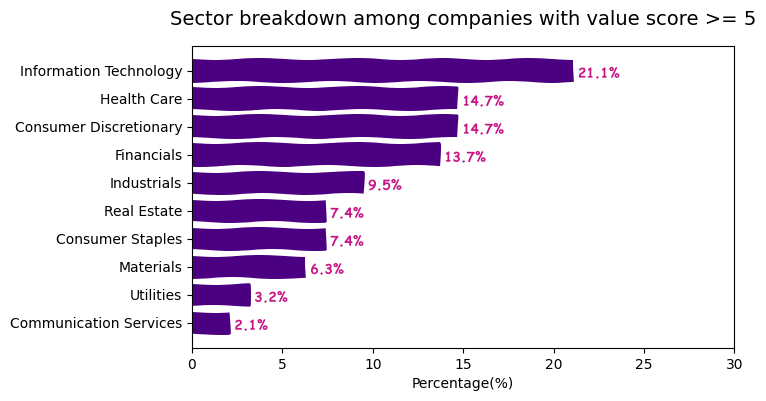

In [29]:
# Select companies with value score >= 5
sp500_vs_5 = sp500_df_final.loc[sp500_df_final["Value Score"] >= 5, :]

# Group companies by sector
grouped_df = sp500_vs_5["Sector"].value_counts()

# Plot a bar chart to show the percentage of each sector among all the companies with value score >=5
fig, ax = plt.subplots(figsize=(7,4), dpi=100)
labels = grouped_df.index
values = np.round(100 * grouped_df.values / grouped_df.values.sum(), 1)

with plt.xkcd():
    ax.barh(labels, values, align="center", color="indigo")
    ax.set_xlabel("Percentage(%)")
    ax.set_xlim(0, 5 * (max(values) // 5 + 2))
    ax.invert_yaxis() # labels read top-to-bottom
    ax.set_title("Sector breakdown among companies with value score >= 5", fontsize="14", pad="15")
    
    for i, v in enumerate(values):
        ax.text(v + 0.25, i + 0.25, str(v) + "%", color='mediumvioletred', fontsize="x-small", fontweight='bold')

    plt.show()

From the bar chart above, we can see that among the companies with a value score of >=5, most of them are in information technology sector, followed by healthcare, consumer discretionary, and financials. Companies in utilities and communication services have the lowest percentage (~2-3% respectively).

## Price-to-Earnings (P/E) Valuation Method - Find the Undervalued Companies

Finally, we'll estimate the fair value of the company using P/E valuation method. <br><br>

<center>$ Estimated fair value (Price) = Estimated  P/E * Estimated  EPS $</center>

You can see from the formula above that the two key elements to calculate the estimated fair value are *estimated P/E* and *estimated EPS*. So, how can we estimate EPS and P/E? 

In this project, I'll use TTM EPS as the surrogate of estimated EPS, with the assumption that the company's future EPS will be at least equal to the latest EPS. To estimate P/E, I'll use the average of the company's 5-year historical P/E. The reason for using 5-year average P/E is that a single P/E value can be affected by various factors such as shorter-term volatility, [inflation](https://www.investopedia.com/ask/answers/123.asp), interest rate, *etc.*. While estimating fair value to be a reference for long-term value investing opportunity, we'd like to get rid of some "noises" as possible.

IEX does not explicitly provide company's historical P/E ratio. So, we'll scrape the information from [Macrotrends](https://www.macrotrends.net/stocks/research), a website that provides very comprehensive financial data and analysis. We will store these data in a Pandas dataframe.

In [30]:
# Create a dataframe to store scraped data
fair_value_df = pd.DataFrame(columns=["Company Name", "Sector", "Estimated EPS (TTM EPS)", "Estimated P/E (5-yr avg)", 
                                      "Current Price ($)", "Estimated Fair Value ($)"], index=sp500_vs_5.index)
fair_value_df["Company Name"] = sp500_vs_5["Company Name"]
fair_value_df["Sector"] = sp500_vs_5["Sector"]

# Create a dictionary with tickers as keys and "slugified" company names as values for the purpose of web scraping 
tickers = list(fair_value_df.index)
names = list(fair_value_df["Company Name"].apply(lambda x: slugify(x)))
comp_dict = dict(zip(tickers, names))

Before scraping the data, let's have a quick glance of a table containing P/E ratio on Macrotrends. We will scrape historical P/E up to 5 years ago from now and the TTM EPS value.
![Image](media/pe-table-ex.png)

In [31]:
# Set current year 
current_year = datetime.now().year

# Scrape current price and 5-year historical P/E data of each company from Macrotrends
for key in comp_dict.keys():

    # Scrape the website containing P/E ratio table 
    try:
        request = requests.get(f"https://www.macrotrends.net/stocks/charts/{key}/{comp_dict[key]}/pe-ratio")
        request.raise_for_status()
    except request.exceptions.HTTPError as e:
        break

    # Create a beautiful soup variable to parse the html
    text = request.text
    soup = BeautifulSoup(text, "html.parser")
    
    # Get the P/E ratio table 
    pe_table = soup.find_all("table")[0] # first table in the website
    
    # Find all the table cells and convert them to text
    rows = pe_table.find_all("td")
    rows_data = [row.text for row in rows]
    num_rows = len(rows)
    
    # Get the current price (at 2nd position of the list of rows data)
    fair_value_df.loc[key, "Current Price ($)"] = float(rows_data[1])
    
    # Get the TTM EPS (at 7th position of the list of rows data)
    fair_value_df.loc[key, "Estimated EPS (TTM EPS)"] = float(rows_data[6][1:]) #slice the string [1:] to remove $ symbol

    # Create an empty list to store 5-year historical P/E data of each company
    pe_data = []

    # Read data row-by-row with increment of 4 (one row contains 4 cells: date, price, eps, p/e)
    for i in range(0, num_rows, 4):
        date = datetime.strptime(rows_data[i], "%Y-%m-%d")
        pe = rows_data[i+3]

        # Calculate difference between current year and the year of the data
        year_diff = current_year - date.year

        # Extract P/E data up to 5-year from now
        if year_diff > 5:
            break

        pe_data.append(pe)

    # Convert P/E from string to float 
    pe_data = np.array([float(val) for val in pe_data])
    
    # Exclude outliers of P/E ratio (>2 * standard deviation)
    mean_pe = np.mean(pe_data)
    std_pe = np.std(pe_data)
    distance_from_mean = abs(pe_data - mean_pe)
    z = 2 # assuming standard normal distribution of historical P/E, 95% of data is within mean +/- 2 std
    not_outlier = distance_from_mean < z * std_pe
    pe_no_outliers = pe_data[not_outlier]
    
    # Calculate average P/E and round to 2 decimal places
    pe_avg = np.round(np.mean(pe_no_outliers), 2)
    fair_value_df.loc[key, "Estimated P/E (5-yr avg)"] = pe_avg
    
# Check if the scraping is successful
fair_value_df.head()

,Company Name,Sector,Estimated EPS (TTM EPS),Estimated P/E (5-yr avg),Current Price ($),Estimated Fair Value ($)
Ticker,,,,,,
TXN,Texas Instruments,Information Technology,6.6,21.81,188.17,NaN
HOLX,Hologic,Health Care,7.29,14.19,65.89,NaN
EXPD,Expeditors,Industrials,5.04,21.38,125.75,NaN
UHS,Universal Health Services,Health Care,11.8,14.58,151.18,NaN
KMB,Kimberly-Clark,Consumer Staples,6.67,20.27,133.07,NaN


Before we proceed with calculation of estimated fair value, let's see if there are any missing values.

In [32]:
fair_value_df.isnull().sum()

Company Name                 0
Sector                       0
Estimated EPS (TTM EPS)      0
Estimated P/E (5-yr avg)     0
Current Price ($)            0
Estimated Fair Value ($)    95
dtype: int64

We can see that except for estimated fair value (which we have not computed), there is no missing value in other columns. Now, let's calculate the estimated fair value and see how many companies have a current price lower than the estimated fair value. These are the potential quality under-valued stocks for investment.

In [33]:
# Calculate estimated fair value of each company
fair_value_df["Estimated Fair Value ($)"] = fair_value_df["Estimated EPS (TTM EPS)"] * fair_value_df["Estimated P/E (5-yr avg)"]

# Get the number of companies with current price lower than estimated fair value
(fair_value_df["Estimated Fair Value ($)"] < fair_value_df["Current Price ($)"]).sum()

53

Let's also create a column to calculate the percentage difference between current price and estimated fair value. A higher percentage implies that the stock is relatively under-valued compared to others.

In [34]:
fair_value_df["% Difference (Fair Value - Current Price)"] = 100* ((fair_value_df["Estimated Fair Value ($)"] - 
                                                             fair_value_df["Current Price ($)"]) / 
                                                             fair_value_df["Current Price ($)"])

Let's take a quick glance at the sector breakdown of these under-valued companies.

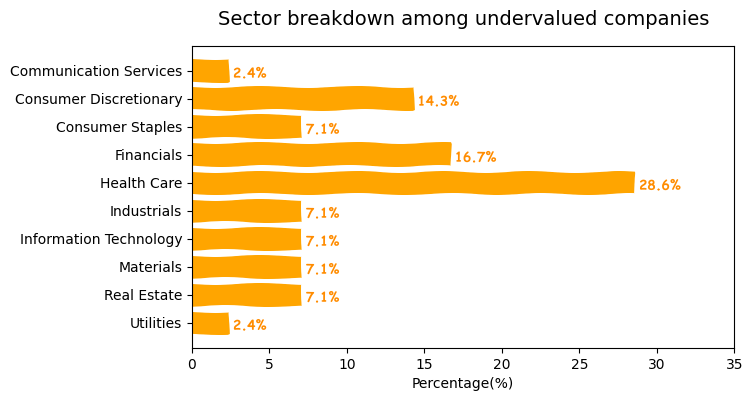

In [35]:
# Select undervalued companies and group them by sector 
undervalued = fair_value_df.loc[fair_value_df["% Difference (Fair Value - Current Price)"] > 0, :]
grouped_df = undervalued.groupby("Sector")["Sector"].count()

# Plot a bar chart to show the percentage of each sector among the undervalued companies
fig, ax = plt.subplots(figsize=(7,4), dpi=100)
labels = grouped_df.index
values = np.round(100 * grouped_df.values / grouped_df.values.sum(), 1)

with plt.xkcd():
    ax.barh(labels, values, align="center", color="orange")
    ax.set_xlabel("Percentage(%)")
    ax.set_xlim(0, 5 * (max(values) // 5 + 2))
    ax.invert_yaxis() # labels read top-to-bottom
    ax.set_title("Sector breakdown among undervalued companies", fontsize="14", pad="15")
    
    for i, v in enumerate(values):
        ax.text(v + 0.25, i + 0.25, str(v) + "%", color='darkorange', fontsize="x-small", fontweight='bold')

    plt.show()

From the bar chart, we can see that healthcare companies, among all the other sectors, are more under-valued at the current juncture. 

Lastly, let's see the ten most undervalued companies, which are our potential investment opportunities.

In [36]:
# Sort the dataframe based on the percentage difference of fair value and current price
fair_value_df.sort_values(by="% Difference (Fair Value - Current Price)", ascending=False, inplace=True)
investment_opportunities = fair_value_df.head(10)
investment_opportunities

,Company Name,Sector,Estimated EPS (TTM EPS),Estimated P/E (5-yr avg),Current Price ($),Estimated Fair Value ($),% Difference (Fair Value - Current Price)
Ticker,,,,,,,
BIO,Bio-Rad Laboratories,Health Care,135.98,48.39,633.56,6580.07,938.587
COO,The Cooper Companies,Health Care,47.43,37.35,396.43,1771.51,346.866
BRK.B,Berkshire Hathaway,Financials,43.97,15.71,278.38,690.769,148.139
VRTX,Vertex Pharmaceuticals,Health Care,10.5,45.63,194.34,479.115,146.534
CINF,Cincinnati Financial,Financials,18.91,15.42,119.08,291.592,144.871
REGN,Regeneron Pharmaceuticals,Health Care,35.33,30.71,550.55,1084.98,97.0728
NEM,Newmont,Materials,3.19,37.22,62.68,118.732,89.4253
LH,LabCorp,Health Care,26.9,17.37,267.24,467.253,74.844
KIM,Kimco Realty,Real Estate,2.36,15.03,21.08,35.4708,68.2676


It is important to note that all the valuation methods are based on some assumptions. In our approach, we assume that company's forward EPS is equal to TTM EPS, and the company's P/E to be an average of 5-year P/E (exclude outliers). The reality is that these assumptions might not hold and the estimated fair value will not be accurate. 

You can use different ways of estimation (e.g. forward P/E instead of trailing P/E, 10-year average P/E instead of 5-year average P/E, forward EPS instead of TTM EPS) and additional valuation methods (e.g. discounted cash flow, [Price/Earnings-to-Growth (PEG) Ratio](https://www.investopedia.com/terms/p/pegratio.asp), [Price-To-Book (P/B Ratio)](https://www.investopedia.com/terms/p/price-to-bookratio.asp), etc.) to see if the same company appears to be under-valued.

## Conclusion

In this project, we have analyzed S&P 500 companies to find 10 fundamentally good and relatively under-valued companies to invest in using value investing principles. The **10 companies** we identify are:
* Healthcare: **BIO, COO, VRTX, REGN, LH**
* Financials: **BRK.B, CINF**
* Information Technology: **AMD**
* Materials: **NEM**
* Real Estate: **KIM**

Before we end off, I would like to discuss some limitations of this project.
* We're only using 3 to 5-year of financial data. Ideally, to make a value investing decision, it is good to analyze longer-term data (at least 5 to 10 years). This allows us to see how companies perform in each economic cycle and if companies are resilient in weathering through challenges and/or financial crisis. 
* Some of the stock data is not accurate as we are using the sandbox environment of IEX data provider. 
* We're filtering companies purely based on the selected value-investing metrics, instead of understanding the fundamental business. In fact, it is very essential to understand the business, company outlook, economic moat, customer base, industry-wide growth, competitive advantage, management, and risks & challenges the company is facing, *etc*.. This is also what Warren Buffet called the "Circle of Competence". Only when you know the business well enough, you can make the best informed investment decision. 